In [1]:
import sys, platform
import numpy as np
import matplotlib.pyplot   as plt
# import vispy as vp
import open3d as o3d
from tqdm import tqdm
print(platform.platform(), sys.platform)
print("Python", str(sys.version).replace('\n', ' '))
print(f"{np.__version__ = }")
print(f"{o3d.__version__ = }")

macOS-12.6.7-arm64-arm-64bit darwin
Python 3.12.11 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 08:03:38) [Clang 14.0.6 ]
np.__version__ = '2.3.3'
o3d.__version__ = '0.19.0'


## 1. Rasterize a Triangle
### Initialize Parameters

In [2]:
# Properties of a triangle
v1, v2, v3 = np.array([[1., 0., -1.],
                       [0., 1., -1.],
                       [0., 0., 0.]])
color = (0., 1., 0.) # Green

# Properties of the camera and image
img_size = (256, 256)
fov_x = 2.0 # Length

In [3]:
# Determine whether given point is inside or outside of given triangle
if False:
    def p_left_line(p, v1, v2):
        """
        Return `True` if the point `p` is lie at the left side of the directed line `v1-v2`.
        In other words, whether `p` is positioned more left than `v2` viewed by `v1`.
        """
        p = np.asarray(p)
        v1 = np.asarray(v1)
        v2 = np.asarray(v2)
        assert p.shape[-1] == 2
        assert v1.shape == (2,)
        assert v2.shape == (2,)

        vec_p = p - v1
        vec_v2 = v2 - v1
        left_float = vec_v2[..., 0] * vec_p[..., 1] - vec_v2[..., 1] * vec_p[..., 0]
        return left_float >= 0

    def p_inside_triangle(p, v1, v2, v3):
        """
        Return `True` if the point `p` is inside of the trianlge `v1-v2-v3`.
        Otherwise return `False`.
        """
        left_line12 = p_left_line(p, v1, v2)
        left_line23 = p_left_line(p, v2, v3)
        left_line31 = p_left_line(p, v3, v1)
        return (left_line12 & left_line23 & left_line31) | ~(left_line12 | left_line23 | left_line31)

plane_x = 2.0, plane_y = 2.0


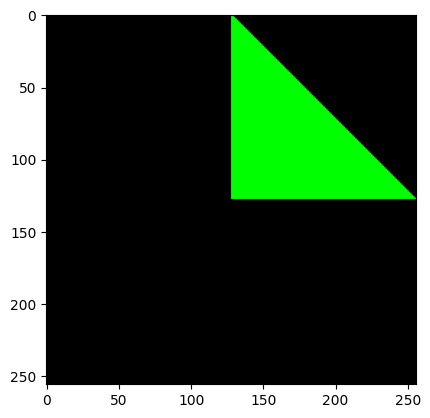

In [4]:
w, h = img_size
def get_pixelXY(img_w, img_h, plane_w, plane_h):
    """
    Parameters
    ----------
    img_w, img_h: int
        Image resolution
    plane_w, plane_h: float
        Size of the virtual image plane
    
    Return
    ------
    X, Y: np.ndarray
        Shape (img_h, img_w) for both
    """
    X, Y = np.meshgrid(((np.arange(img_w)+0.5)/img_w - 0.5) * plane_w,
                       ((np.arange(img_h)[::-1]+0.5)/img_h - 0.5) * plane_h,
                       indexing='xy')
    return X, Y

plane_x = fov_x
# plane_x = np.tan(np.deg2rad(fov_x)/2)*2 # For perspective
plane_y = plane_x * h / w
print(f"{plane_x = }, {plane_y = }")

X_img, Y_img = get_pixelXY(w, h, plane_x, plane_y)

img = np.zeros(img_size + (3,))

def barycentric_coords(X_img, Y_img, v1, v2, v3):
    """
    Parameters
    ----------
    X_img, Y_img: np.ndarray[...]
        x and y coordinates of a virtual image plane (e.g., z=-1).
        They should be returns of `get_pixelXY()` 
    v1, v2, v3: np.ndarray[3]
        Vertices of a triangle
    
    Return
    ------
    alpha, beta: np.ndarray[...]
        Shape of each must be identical to those of `X_img` and `Y_img`.
    """
    a = v3[:2] - v1[:2]
    b = v3[:2] - v2[:2]
    c = v3[:2] - np.stack([X_img, Y_img], -1)
    D = a[0]*b[1] - a[1]*b[0] # shape [...]
    Minv = np.stack([np.stack([b[1], -b[0]], -1),
                     np.stack([-a[1], a[0]], -1)],-2)
    alpha, beta = np.moveaxis((Minv @ c[..., None]).squeeze(-1), -1, 0)
    return alpha/D, beta/D

alpha, beta = barycentric_coords(X_img, Y_img, v1, v2, v3)

def is_barycentric_inside(alpha, beta):
    return (alpha >= 0.) & (alpha <= 1.) & (beta >= 0.) & (beta <= 1.) & (alpha+beta <= 1.)

mask = is_barycentric_inside(alpha, beta)
img[mask] = color
plt.imshow(img);

### Diffuse Shading with a Point Light
Barycentric coordinates:
$$
\alpha v_1 + \beta v_2 + \left(1-\alpha-\beta\right) v_3 = p
$$

$$
\begin{bmatrix}
    v_1-v_3 & v_2-v_3
\end{bmatrix}\begin{bmatrix}
    \alpha\\\beta
\end{bmatrix} = p - v_3
$$

$$
a \coloneqq v_3 - v_1 \\
b \coloneqq v_3 - v_2 \\
c \coloneqq v_3 - p
$$

Let $p_l\in\R^3$ (`light_position`) and $I$ (`light_intensity`) be the position and intensity of a point light source.
$$
\frac{1}{\left|p - p_l\right|^2} \left(\hat n\cdot \hat{\left(p-p_l\right)}\right) c
$$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1936074337601894].


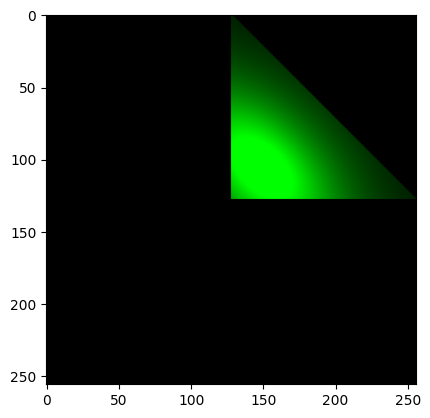

In [5]:
#%% Parmaeters
light_position = np.array([0.5, 0.5, 0.]) 
light_intensity = 1.25

#%% Render
def triangle_normal(v1, v2, v3):
    cross = np.cross(v2-v1, v3-v1)
    norm = np.linalg.norm(cross)
    return cross / norm

img = np.zeros(img_size + (3,))

gamma = 1-alpha-beta
p = v1*alpha[..., None] + v2*beta[..., None] + v3*gamma[..., None]
assert np.allclose(X_img - p[..., 0], 0)
assert np.allclose(Y_img - p[..., 1], 0)
d = light_position - p
n = triangle_normal(v1, v2, v3)

d_masked = d[mask]

img[mask] = (n*d_masked).sum(-1, keepdims=True) * color / np.linalg.norm(d_masked, 2, -1, keepdims=True)**3 * light_intensity / np.pi
plt.imshow(img);

## 2. Rasterize Many Triangles
### Read `.obj` file

In [6]:
# obj_file = "resource/bunny_300tri.obj"
obj_file = "resource/bunny_100tri.obj"
mesh = o3d.io.read_triangle_mesh(obj_file)

print(f"{type(mesh) = }")
print(f"{type(mesh.vertices) = }")
print(f"{type(mesh.triangles) = }\n")

arr_vertices = np.asarray(mesh.vertices)
arr_triangles = np.asarray(mesh.triangles)
print(f"{arr_vertices.shape = }")
print(f"{arr_triangles.shape = }")

type(mesh) = <class 'open3d.cpu.pybind.geometry.TriangleMesh'>
type(mesh.vertices) = <class 'open3d.cpu.pybind.utility.Vector3dVector'>
type(mesh.triangles) = <class 'open3d.cpu.pybind.utility.Vector3iVector'>

arr_vertices.shape = (376, 3)
arr_triangles.shape = (182, 3)


**Note:** Vertex order may be changed.

In [7]:
print("# Open3D data:\n", arr_vertices[:5, :])
with open(obj_file) as f:
    obj_text = f.read()

print("\n# `.obj` text file:")
print("\n".join(obj_text.split("\n")[:9]))

# Open3D data:
 [[-0.025403    0.123613   -0.003379  ]
 [-0.048248    0.13677201  0.014896  ]
 [-0.023999    0.12508     0.019287  ]
 [-0.031332    0.15650301 -0.003836  ]
 [-0.058775    0.156633    0.010871  ]]

# `.obj` text file:
# Blender 4.4.3
# www.blender.org
o bunny_100
v -0.031332 0.156503 -0.003836
v -0.048248 0.136772 0.014896
v -0.051376 0.134933 -0.001553
v -0.041529 0.172773 -0.001792
v -0.059948 0.145685 0.035268
v -0.025403 0.123613 -0.003379


Check the data was properly load, via existing viewer API

In [8]:
'''
It makes a pop-up window.
'''
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(mesh)
vis.run()
vis.destroy_window()

### Check how naively iterating the process in Step 1 fails

In [9]:
class RendererNaive:
    def __init__(self, fov_x, img_w, img_h):
        # FOV usually indicates an angle, but here a length
        assert fov_x > 0.0
        assert isinstance(img_w, int)
        assert isinstance(img_h, int)
        self.fov_x = fov_x
        self.img_w = img_w
        self.img_h = img_h

        plane_x = fov_x
        plane_y = plane_x * img_h / img_w

        self.X_img, self.Y_img = get_pixelXY(img_w, img_h, plane_x, plane_y)

        self.img = np.zeros((img_h, img_w, 3))
    
    def render_triangle(self,
                        light_position, light_intensity,
                        v1, v2, v3, color):
        alpha, beta = barycentric_coords(self.X_img, self.Y_img, v1, v2, v3)
        mask = is_barycentric_inside(alpha, beta)

        gamma = 1-alpha-beta
        p = v1*alpha[..., None] + v2*beta[..., None] + v3*gamma[..., None]
        assert np.allclose(self.X_img - p[..., 0], 0)
        assert np.allclose(self.Y_img - p[..., 1], 0)
        d = light_position - p
        n = triangle_normal(v1, v2, v3)

        d_masked = d[mask]

        self.img[mask] = (n*d_masked).sum(-1, keepdims=True) * color / np.linalg.norm(d_masked, 2, -1, keepdims=True)**3 * light_intensity / np.pi
        return self.img

Set a camera at an appropriate position so that all vertices are visible from the camera

In [10]:
bbox_min = arr_vertices.min(0)
bbox_max = arr_vertices.max(0)
print(f"{bbox_min = }")
print(f"{bbox_max = }")

# FOV usually indicates an angle, but here a length
fov = 2 * max(*np.abs(bbox_min[:2]), *np.abs(bbox_max[:2]))
print(f"{fov = }")

bbox_min = array([-0.091986,  0.033276, -0.061056])
bbox_max = array([0.061673  , 0.18494099, 0.057385  ])
fov = np.float64(0.3698819875717163)


* Elapsed time: 3.8s for AMD Ryzen 7700 (2022 year) 8-Core Processor (3.80 GHz), when tested with `bunny_300tri.obj`

100%|██████████| 182/182 [00:00<00:00, 186.82it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11.036889424920973..22.792962184010676].


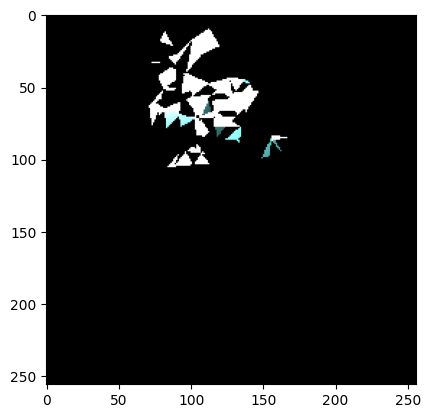

In [11]:
#%% Parameters
fov_x = 0.4
w, h = 256, 256
light_position = np.array([-0.1, 0.2, 0.1]) 
light_intensity = 0.75
color = (0.4, 0.8, 0.8)

#%% Render
renderer = RendererNaive(fov_x, w, h)
for tri in tqdm(arr_triangles): # Try `arr_triangles[::-1]` instead of `arr_triangles`
    assert tri.shape == (3,)
    v1 = arr_vertices[tri[0]]
    v2 = arr_vertices[tri[1]]
    v3 = arr_vertices[tri[2]]
    renderer.render_triangle(light_position, light_intensity,
                             v1, v2, v3, color)
plt.imshow(renderer.img);

### Depth buffer

100%|██████████| 182/182 [00:00<00:00, 187.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.157760774400461..23.03317367740367].


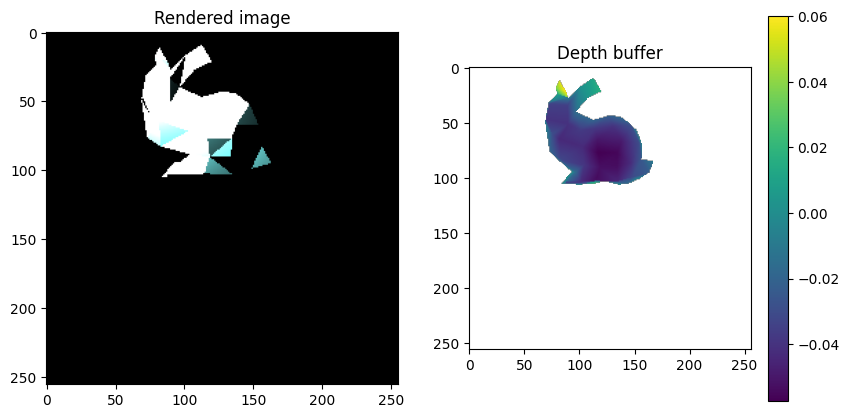

In [12]:
class RendererV1(RendererNaive):
    """
    V1: Add a depth buffer for a proper rendering
    """
    def __init__(self, fov_x, img_w, img_h):
        super().__init__(fov_x, img_w, img_h)
        self.depth = np.full((img_h, img_w), np.inf) # Depth buffer
    
    def render_triangle(self,
                        light_position, light_intensity,
                        v1, v2, v3, color):
        alpha, beta = barycentric_coords(self.X_img, self.Y_img, v1, v2, v3)
        mask = is_barycentric_inside(alpha, beta)

        gamma = 1-alpha-beta
        p = v1*alpha[..., None] + v2*beta[..., None] + v3*gamma[..., None]
        assert np.allclose(self.X_img - p[..., 0], 0)
        assert np.allclose(self.Y_img - p[..., 1], 0)
        d = light_position - p
        n = triangle_normal(v1, v2, v3)
        
        # Theese three lines are the only difference
        depth_tri = -p[..., 2] # Negative sign due to "-Z" is forward
        # print(f"1. {mask.sum() = }")
        mask = mask & (depth_tri < self.depth)
        # print(f"2. {mask.sum() = }")
        self.depth[mask] = depth_tri[mask]

        d_masked = d[mask]

        self.img[mask] = (n*d_masked).sum(-1, keepdims=True) * color / np.linalg.norm(d_masked, 2, -1, keepdims=True)**3 * light_intensity / np.pi
        return self.img
    
    def render_obj(self, light_position, light_intensity, arr_vertices, arr_triangles, color):
        for tri in tqdm(arr_triangles): # Try `arr_triangles[::-1]` instead of `arr_triangles`
            assert tri.shape == (3,)
            v1 = arr_vertices[tri[0]]
            v2 = arr_vertices[tri[1]]
            v3 = arr_vertices[tri[2]]
            renderer.render_triangle(light_position, light_intensity,
                                    v1, v2, v3, color) # Update `self.img`
        return self.img
            
renderer = RendererV1(fov_x, w, h)
img = renderer.render_obj(light_position, light_intensity, arr_vertices, arr_triangles, color)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(renderer.img)
axes[0].set_title("Rendered image")
im = axes[1].imshow(renderer.depth)
axes[1].set_title("Depth buffer")
fig.colorbar(im)

## 3. Shading
Let's try various shading:
* Lights: point, directional + ambient
* Material: diffuse, specular

(+ applying gamma correction will be good to see the results)